# Perceptron Lab





In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import Perceptron
from scipy.io import arff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 1. (40%) Correctly implement and submit your own code for the perceptron learning algorithm. 

### Code requirements
#### Complete
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e. do not attempt batch updates)
- Implement a stopping criterion: when your model has trained for a number of epochs with no significant improvement in accuracy, stop training. Note that the weights/accuracy do not usually change monotonically.
#### ToDo
- Shuffle the data each epoch.
- Use your perceptron to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your perceptron on the Evaluation data with the same parameters, and print your final weights and accuracy.

In [2]:
class PerceptronClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self, lr =.1, shuffle = True):
        self.lr = lr
        self.shuffle = shuffle
        self.weights = None
        self.epochs_run = 0
        self.misclassified = []
        
    def __str__(self):
        output = "Weights: "
        output += str(self.weights) if self.weights is not None else "[ ]"
        output += f"\nEpochs run: {self.epochs_run}"
        return output

    def fit(self, X, y, epochs=0, stopping_criteria=False, initial_weights=None):
        self.weights = initial_weights if initial_weights is not None else np.zeros(len(X.T)+1)
        # self.weights = initial_weights if initial_weights is not None else np.array([np.random.random() for _ in range(len(X.T)+1)])
        
        if not stopping_criteria:
            for epoch in range(int(epochs)):
                misclassified = 0
                if self.shuffle:
                    X, y = self._shuffle_data(X, y)
                for inputs, target in zip(X, y):
                    self.weights += (dw := self._get_updates(inputs, target))
                    misclassified += int(any(dw))
                self.misclassified.append(misclassified)
            self.epochs_run = epochs
        else:
            best_score = self.score(X, y)
            curr_epochs=epochs
            while curr_epochs > 0:
                self.epochs_run += 1
                misclassified=0
                if self.shuffle:
                    X, y = self._shuffle_data(X, y)
                for inputs, target in zip(X, y):
                    self.weights += (dw := self._get_updates(inputs, target))
                    misclassified += int(any(dw))
                self.misclassified.append(misclassified)
                
                curr_score = self.score(X,y)
                if curr_score > best_score:
                    best_score = curr_score
                    curr_epochs = epochs
                else:
                    curr_epochs -= 1

        return self
                    
    
    def _get_updates(self, inputs, target):
        inputs = np.concatenate((inputs, [1]))
        output = np.dot(inputs, self.weights)
        output = int(output > 0)
        d_w = (np.array([self.lr*(target - output)*x_i for x_i in inputs]) if target != output 
                   else np.zeros((len(inputs))))
        return d_w

    def predict(self, X):
        outputs = np.array([np.dot(self.weights, inputs) for inputs in np.concatenate((X, np.ones((len(X),1))), axis=1)])
        return (outputs > 0).astype(int)

    def score(self, X, y):
        correct = np.sum(self.predict(X) == y)
        return correct / len(y)

    def _shuffle_data(self, X, y):
        data = np.concatenate((X, np.array((y,)).T), axis=1)
        np.random.shuffle(data)
        return data[:,:-1], data[:,1]

    def get_weights(self):
        return self.weights

## 1.1 Debug and Evaluation

Debug and Evaluate your model using the parameters below

Learning Rate = 0.1\
Deterministic = 10 [i.e., run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Initial Weights = All zeros

---

### 1.1.1 Debug

Debug your model by running it on the [debug dataset](https://byu.instructure.com/files/4421290/download?download_frd=1)

Expected Results:

Accuracy = [0.88]\
Final Weights = [-0.23  0.18 -0.1 ]

In [3]:
# Load debug data
data, meta = arff.loadarff("data/linsep2nonorigin.arff")
data = np.array([[*row] for row in data]).astype(float)
X, y = data[:, :-1], data[:, -1]

# Train on debug data
clfr = PerceptronClassifier(shuffle=False)
clfr.fit(X, y, epochs=10, stopping_criteria=False)
print( clfr.score(X, y))
print(clfr)

0.875
Weights: [-0.23  0.18 -0.1 ]
Epochs run: 10


### 1.1.2 Evaluation

We will evaluate your model based on it's performance on the [evaluation dataset](https://byu.instructure.com/files/4421294/download?download_frd=1)

In [4]:
# Load evaluation data
data, meta = arff.loadarff("data/data_banknote_authentication.arff")
data = np.array([[*row] for row in data]).astype(float)
X, y = data[:, :-1], data[:, -1]
data
# Train on evaluation data
clfr = PerceptronClassifier(shuffle=False)
clfr.fit(X, y, epochs=10, stopping_criteria=False)
# Print accuracy and weights
print(clfr.score(X,y))
print(clfr)


0.9876093294460642
Weights: [-3.80657242 -2.840821   -3.0719334  -1.4003906   4.9       ]
Epochs run: 10


## 2. (30%) Classifying on linearly separable and non-linearly separable data

### 2.1 Create 2 datasets

- Both with 8 instances using 2 real valued inputs (ranging between -1 and 1) with 4 instances from each class. 
- One data set should be linearly separable and the other not.



In [5]:
# Create .2 datasets
lin_sep_data = np.array([
    [.1, .1, 0],
    [.3, .2, 0],
    [.1, 1,  0],
    [.4, .2, 0],
    [.5, .2, 1],
    [.7, .1, 1],
    [.4, .6, 1],
    [.3, .8, 1]
])

non_lin_sep_data = np.array([
    [.1, .1, 0],
    [.7, .1, 0],
    [.1, 1,  0],
    [.4, .2, 0],
    [.5, .2, 1],
    [.3, .2, 1],
    [.4, .6, 1],
    [.3, .8, 1]
])

### 2.2 Train on both sets with your perceptron code (with LR=.1)

In [6]:
# Train on each dataset
lin_clfr = PerceptronClassifier(shuffle=False)
X, y = lin_sep_data[:,:2], lin_sep_data[:,2]
print(lin_clfr.fit(X, y, epochs=100, stopping_criteria=True).score(X, y))
print(lin_clfr)
print()

non_lin_clfr = PerceptronClassifier(shuffle=False)
X, y = non_lin_sep_data[:,:2], non_lin_sep_data[:,2]
print(non_lin_clfr.fit(X, y, epochs=10000, stopping_criteria=True).score(X, y))
print(non_lin_clfr)


1.0
Weights: [ 0.43  0.09 -0.2 ]
Epochs run: 122

0.5
Weights: [ 1.80000000e-01  1.70000000e-01 -2.77555756e-17]
Epochs run: 10015


lin_line 0.43 0.09 -0.2
non_lin_line 0.18 0.17 -0.0


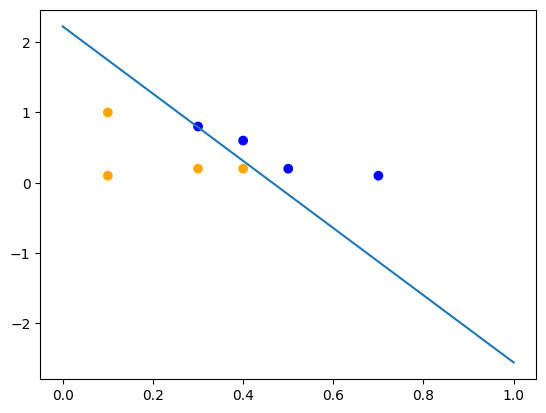

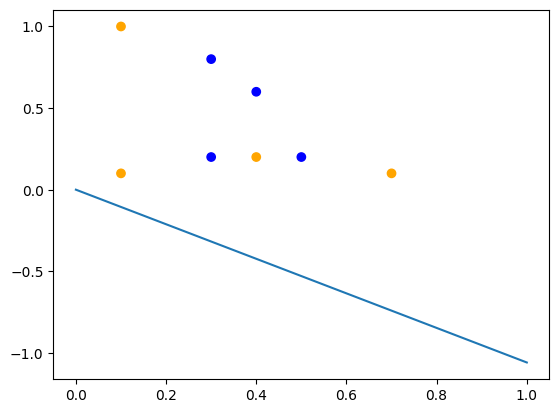

In [7]:
# Prepare graph line
x, y, b = lin_clfr.get_weights()
lin_line = [[i/10 for i in range(11)], [(x*i/10 + b)/-y for i in range(11)]]
print("lin_line", round(x,3), round(y,3), round(b, 3))
x, y, b = non_lin_clfr.get_weights()
print("non_lin_line", round(x,3), round(y,3), round(b,3))
non_lin_line = [[i/10 for i in range(11)], [(x*i/10 + b)/-y for i in range(11)]]
# Graph datasets and decision lines
plt.scatter(*lin_sep_data[:,:2].T, c=list(map(['orange', 'blue'].__getitem__, lin_sep_data[:,2].astype(int))))
plt.plot(*lin_line)
plt.show()

plt.scatter(*non_lin_sep_data[:,:2].T, c=list(map(['orange', 'blue'].__getitem__, non_lin_sep_data[:,2].astype(int))))
plt.plot(*non_lin_line)
plt.show()


### 2.4 Discuss why the perceptron won’t converge on non-linearly separable data.
The whole idea of a perceptron is essentially a fancy way of describing a linear combination, where some proportion of each of `[x_1, x_2, x_3 ... x_n]` are combined by adding to get `y`. If looked at in graph form, each of the `x_i` terms could be seen as a new axis of movement. To get to `y` (some point in space), one would only need to specify how much in each axis to move. The resulting coefficients would represent a  straight line pointing straight towards point `y` (a vector). As a result, the results of a perceptron will inevitably be linear.

## 3. (20%) Use your perceptron code to learn this version of the [voting data set](https://byu.instructure.com/files/4421311/download?download_frd=1).

This particular task is an edited version of the standard voting set, where we have replaced all the “don’t know” values with the most common value for the particular attribute.  

### 3.1 Create a table that reports the final training and test set accuracy and the number of epochs for each trial.

- Try it five times with different random 70/30 splits. 
- Use your own code to randomize and make splits. 
- Report the 5 trials and the average across the 5 trials in a table.  

| Trial | Training Accuracy | Test accuracy | Number of epochs |
| --- | --- | --- | --- |
| 1 | .95 | .55 | 4 |
| 2 | .85 | .45 | 6 |
| Average | .9 | .5 | 5 | 

*- As a rough sanity check, typical Perceptron test accuracies for the voting data set are 90%-98%.*

In [8]:
data, meta = arff.loadarff("data/voting-dataset.arff")
data = np.array([[*row] for row in data])
data = np.where(data==b'n', 0, data)
data = np.where(data==b'y', .1, data)
data = np.where(data==b'democrat', 0, data)
data = np.where(data==b'republican', .1, data)
data = data.astype(float)
X, y = data[:, :-1], data[:, -1]
X

data

array([[0. , 0.1, 0.1, ..., 0.1, 0.1, 0. ],
       [0. , 0. , 0.1, ..., 0. , 0.1, 0.1],
       [0. , 0.1, 0.1, ..., 0. , 0. , 0. ],
       ...,
       [0. , 0.1, 0. , ..., 0. , 0.1, 0.1],
       [0. , 0. , 0. , ..., 0. , 0.1, 0.1],
       [0. , 0.1, 0. , ..., 0. , 0. , 0.1]])

In [9]:
clfr = PerceptronClassifier(shuffle=True)
clfr.fit(X, y, epochs=1000, stopping_criteria=False)
print(clfr)
clfr.score(X, y)

Weights: [-1.00000000e-02  3.00000000e-01  4.00000000e-02 -6.00000000e-02
  7.38389384e-14  1.00000000e-02 -2.00000000e-02  1.00000000e-02
  2.00000000e-02 -1.00000000e-02  2.00000000e-02 -1.00000000e-02
 -1.00000000e-02  7.00000000e-02  1.00000000e-02  1.00000000e-02
 -1.00000000e-01]
Epochs run: 1000


0.6030368763557483

In [10]:
# Create the table any way you like
def split_data(data, train_prop=.7):
    np.random.shuffle(data)
    i = int(len(data)*train_prop) 
    return data[:i, :], data[i:,:]


clfrs = [PerceptronClassifier() for _ in range(5)]

trials = list()
for i, clfr in enumerate(clfrs):
    print(f"split {i+1}...")
    train, test = split_data(data)
    X_train, y_train = train[:,:-1], train[:,-1]
    X_test, y_test = test[:,:-1], test[:,-1]
    clfr.fit(X_train, y_train, epochs=100, stopping_criteria=True, initial_weights = np.random.normal(0, .1, len(X_train.T)+1))
    trials.append([i+1, clfr.score(X_train, y_train), clfr.score(X_test, y_test), clfr.epochs_run])

trials_df = pd.DataFrame(trials, columns=["Trial", "Training Accuracy", "Test accuracy", "Number of epochs"])
trials_df = trials_df.set_index("Trial", drop=True)
trials_df.loc["Average"] = trials_df.mean()
trials_df

split 1...
split 2...
split 3...
split 4...
split 5...


,Training Accuracy,Test accuracy,Number of epochs
Trial,,,
1,0.562112,0.697842,100.0
2,0.608696,0.589928,100.0
3,0.596273,0.618705,101.0
4,0.608696,0.589928,100.0
5,0.602484,0.604317,101.0
Average,0.595652,0.620144,100.4


In [11]:
labels = list(meta._attributes.keys())
for label, value in zip(labels, clfrs[0].get_weights()):
    print(f"{label}: {round(value,3)}")

handicapped-infants: 0.013
water-project-cost-sharing: 0.249
adoption-of-the-budget-resolution: -0.011
physician-fee-freeze: 0.027
el-salvador-aid: -0.003
religious-groups-in-schools: -0.028
anti-satellite-test-ban: -0.041
aid-to-nicaraguan-contras: -0.022
mx-missile: 0.017
immigration: -0.023
synfuels-corporation-cutback: -0.003
education-spending: 0.002
superfund-right-to-sue: 0.02
crime: -0.015
duty-free-exports: 0.001
export-administration-act-south-africa: -0.019
Class: -0.097


### 3.2 By looking at the weights, explain what the model has learned and how the individual input features affect the result. Which specific features are most critical for the voting task, and which are least critical? 


It seems that some attributes affect the likelihood that someone will vote republican vs democrat more than others. For instance, the most indicitive factor for someone voting republican seemed to be the **water project cost sharing**, with the **Class** and **superfund right to sue** issues also contributing somewhat. On the other hand, issues such as the **synfuels corporation cutback** and the **el salvador aid** seemed to influence the person to vote democrat. Others, such as the **export administration act south africa** and the **mx missile** didn't seem to have much of an effect. <br><br>The weights here were very low. This is probably because my accuracy was so low, so it had very little predictive power.

### 3.3 Make a graph of the average misclassification rate vs epochs (0th – final epoch).

- Average the misclassification rate for the training set across your 5 trials (not across 5 epochs).


![Average Misclassification Rate](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/avg_misclassification_rate_vs_epochs.png)

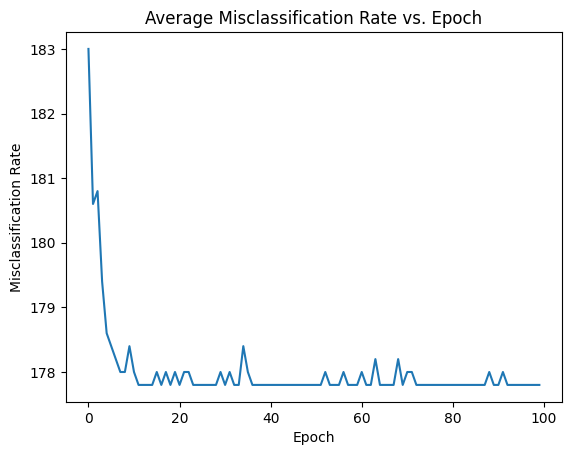

[183.  180.6 180.8 179.4 178.6 178.4 178.2 178.  178.  178.4 178.  177.8
 177.8 177.8 177.8 178.  177.8 178.  177.8 178.  177.8 178.  178.  177.8
 177.8 177.8 177.8 177.8 177.8 178.  177.8 178.  177.8 177.8 178.4 178.
 177.8 177.8 177.8 177.8 177.8 177.8 177.8 177.8 177.8 177.8 177.8 177.8
 177.8 177.8 177.8 177.8 178.  177.8 177.8 177.8 178.  177.8 177.8 177.8
 178.  177.8 177.8 178.2 177.8 177.8 177.8 177.8 178.2 177.8 178.  178.
 177.8 177.8 177.8 177.8 177.8 177.8 177.8 177.8 177.8 177.8 177.8 177.8
 177.8 177.8 177.8 177.8 178.  177.8 177.8 178.  177.8 177.8 177.8 177.8
 177.8 177.8 177.8 177.8]


In [12]:
# Graph here
min_epochs = len(min(clfrs, key=lambda c: len(c.misclassified)).misclassified)
misclassified = np.array([c.misclassified[:min_epochs] for c in clfrs])
avg_misclfs = np.average(misclassified, axis=0)
    
def plot_misclassification(avg_misclassification_rate):
    """
        Plots the average misclassification rate
    Args:
        avg_misclassification_rate (array-like): A 1D array or list
    """
    plt.plot(np.arange(len(avg_misclassification_rate)), avg_misclassification_rate)
    plt.title("Average Misclassification Rate vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Misclassification Rate")
    plt.show()
    

plot_misclassification(avg_misclfs)
print(avg_misclfs)

## 4.1 (5%) Use the perceptron algorithm from the [scikit-learn toolkit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) to learn the voting task above.
- Report and compare your results with your own perceptron code.

In [13]:
data, meta = arff.loadarff("data/voting-dataset.arff")
data = np.array([[*row] for row in data])
data = np.where(data==b'n', 0, data)
data = np.where(data==b'y', 1, data)
data = np.where(data==b'democrat', 0, data)
data = np.where(data==b'republican', 1, data)
data = data.astype(int)
X, y = data[:, :-1], data[:, -1]
X


array([[0, 1, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 0, 1],
       [0, 1, 1, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 1, 0, ..., 1, 0, 0]])

In [14]:
# Load sklearn perceptron
prn = Perceptron()

# Train on voting dataset
prn.fit(X, y)
print(prn.score(X, y))
dir(prn)
labels = list(meta._attributes.keys())
for label, value in zip(labels, prn.coef_[0]):
    print(f"{label}: {round(value,3)}")

0.9609544468546638
handicapped-infants: 0.0
water-project-cost-sharing: -3.0
adoption-of-the-budget-resolution: -8.0
physician-fee-freeze: 17.0
el-salvador-aid: 4.0
religious-groups-in-schools: -2.0
anti-satellite-test-ban: 5.0
aid-to-nicaraguan-contras: 6.0
mx-missile: -7.0
immigration: 5.0
synfuels-corporation-cutback: -10.0
education-spending: -1.0
superfund-right-to-sue: -1.0
crime: 0.0
duty-free-exports: -4.0
export-administration-act-south-africa: 5.0


*Report your comparison*

Listed above are the different topics in questions, with the weights of how much they correlate to voting republican. *(repub**1**ican, dem**0**crat haha)*. For instance: it would seem that agreeing with the **physician fee freeze** is highly associated with voting republicaan. Other strong associations are aggreeing with the **immigration** issue, the **anti-satellite test ban**, and with **education spending**. <br><br> On the other hand, agreeing with the **synfuels corporation cutback** is strongly associated with voting democrat. Other strong associations are agreeing with the **adoption of budget resolutions**, supporting **duty free exports**, and supporting the **mx missile**. <br><br> Finally, other attributes had little association with either. Some include the issue of **handicapped infants** and of **export administration act south africa**.


## 4.2 (5%) Use the perceptron algorithm from the [scikit-learn toolkit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) to learn one other data set of your choice.
- Try out some of the hyper-parameters that scikit-learn makes available.

In [15]:
# Load sklearn perceptron
heart_data = pd.read_csv("data/heart_failure_clinical_records_dataset.csv")
#Normalize the data
heart_data = (heart_data-heart_data.min())/(heart_data.max() - heart_data.min())
X_train = heart_data.iloc[:int(len(heart_data)*.8), :-1]
X_test = heart_data.iloc[int(len(heart_data)*.8):, :-1]
y_train = heart_data.iloc[:int(len(heart_data)*.8), -1]
y_test = heart_data.iloc[int(len(heart_data)*.8):, -1]
X_test

# Train on your dataset
heart_clfrs = [
    Perceptron(),
    Perceptron(shuffle=False),
    Perceptron(early_stopping=True),
    Perceptron(early_stopping=True, n_iter_no_change=10),
    Perceptron(early_stopping=True, n_iter_no_change=100),
    Perceptron(early_stopping=True, validation_fraction=.05, n_iter_no_change=10),
    Perceptron(early_stopping=True, validation_fraction=.25, n_iter_no_change=10),
    Perceptron(tol=None, max_iter=1000),
    Perceptron(fit_intercept=False),
]

scores = []
for heart_clfr in heart_clfrs:
    heart_clfr.fit(X_train, y_train)
    scores.append(heart_clfr.score(X_test, y_test))

for i, score in enumerate(scores):
    print(f"{i}: {score}")

0: 0.95
1: 0.95
2: 0.95
3: 0.95
4: 0.95
5: 0.95
6: 0.9166666666666666
7: 0.9
8: 0.95


*Report what hyperparameters you experimented with & what performed well*
I experimented with several different hyperparameters. The experiments were as follows:
<ol>
    <li>Standard perceptron</li>
    <li>No data shuffling</li>
    <li>Experimented with early stopping</li>
    <li>Early stopping: increased iterations without change to 10</li>
    <li>Early stopping: increased iterations without change to 100</li>
    <li>Early stopping: increased iterations without change to 10, decreased validation fraction to 0.05</li>
    <li>Early stopping: increased iterations without change to 10, increased validation fraction to 0.25</li>
    <li>Changed to iterating for exactly 1000 iterations</li>
    <li>Does not attempt to center data</li>
</ol>

As can be seen above, all sets of hyperparameters performed identically, with a **95% accuracy**, except for `6` and `7`. Evidently, raising the validation fraction too high didn't leave the perceptron with enough data to train with. Also, they evidently ran for more than 1000 epochs.

## 5. (Optional 5% extra credit) Use the perceptron rule to learn the [iris task](https://byu.instructure.com/files/4421369/download?download_frd=1) or some other task with more than two possible output values. 

Note that the [iris data](https://byu.instructure.com/files/4421369/download?download_frd=1) set has 3 output classes, and a perceptron node only has two possible outputs.  You could implement either of the two most common ways to deal with this. For testing you just execute the novel instance on each model and combine the overall results to see which output class wins.